In [ ]:
# -*- coding: utf-8 -*-
# ---
# jupyter:
#   jupytext:
#     text_representation:
#       extension: .py
#       format_name: light
#       format_version: '1.5'
#       jupytext_version: 1.14.5
#   kernelspec:
#     display_name: Python 3 (ipykernel)
#     language: python
#     name: python3
# ---

# # pySCENIC Downstream Analysis and Visualization
#
# This notebook guides you through loading expression data from a CSV,
# performing standard single-cell preprocessing, loading AUCell scores and regulon data
# (produced by the pySCENIC Docker script), integrating them,
# and performing common visualizations and analyses.

# ## 1. Setup: Import Libraries and Define Paths

# ### 1.1 Import Libraries
import os
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast

# pySCENIC specific imports (especially for SCope export and potentially regulon handling)
from pyscenic.export import export2loom
from pyscenic.utils import load_motifs

# Set Scanpy plotting aesthetics (optional)
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=False)
sc.settings.figdir = './figures/' # Directory to save figures
# sns.set_style("ticks")

# ### 1.2 Define Paths
# !!! IMPORTANT: Update these paths to match your system and data !!!

# --- Project Directory (where outputs of this notebook will be saved) ---
NOTEBOOK_OUTPUT_DIR = "pyscenic_downstream_analysis_outputs"
os.makedirs(NOTEBOOK_OUTPUT_DIR, exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)


# --- Path to your Expression CSV file ---
# Assumes the CSV is in a folder named "expressionData" in the current working directory.
# The CSV should ideally have cells as rows and genes as columns.
# If genes are rows, it will need to be transposed.
EXPRESSION_DATA_DIR = ("expressionData")
# !!! REPLACE 'YOUR_EXPRESSION_DATA.csv' with your actual file name !!!
PATH_TO_EXPRESSION_CSV = "/home/waqar/Documents/pySCENIC/raw_feature_bc_matrix/expressionData/expr_matrix_for_scenic.tsv"
# Example: PATH_TO_EXPRESSION_CSV = os.path.join(EXPRESSION_DATA_DIR, "filtered_counts.csv")
ASSUME_CSV_CELLS_ARE_ROWS = True # Set to False if your CSV has genes as rows, cells as columns

# --- Paths to pySCENIC outputs (from the Docker script) ---
PYSCENIC_RESULTS_DIR = "/home/waqar/Documents/pySCENIC/raw_feature_bc_matrix/results" # USER-PROVIDED PATH

PATH_TO_AUCELL_MTX = os.path.join(PYSCENIC_RESULTS_DIR, "aucell_matrix.csv")
PATH_TO_REGULONS_CSV = os.path.join(PYSCENIC_RESULTS_DIR, "regulons.csv")

# --- Output file names for this notebook ---
F_ANNDATA_PREPROCESSED = os.path.join(NOTEBOOK_OUTPUT_DIR, "adata_preprocessed.h5ad")
F_ANNDATA_WITH_SCENIC = os.path.join(NOTEBOOK_OUTPUT_DIR, "adata_with_pyscenic.h5ad")
F_LOOM_FOR_SCOPE = os.path.join(NOTEBOOK_OUTPUT_DIR, "adata_pyscenic_for_scope.loom")

In [15]:
# ## 2. Load Data

# ### 2.1 Load AUCell Matrix
print(f"Loading AUCell matrix from: {PATH_TO_AUCELL_MTX}")
if not os.path.exists(PATH_TO_AUCELL_MTX):
    raise FileNotFoundError(f"AUCell matrix file not found: {PATH_TO_AUCELL_MTX}. Please check the path.")
auc_mtx = pd.read_csv(PATH_TO_AUCELL_MTX, index_col=0) # Cells as rows, Regulons as columns
print(f"Loaded AUCell matrix: {auc_mtx.shape} (cells x regulons)")
print("AUCell matrix head:")
print(auc_mtx.head())

# ### 2.2 Load Regulons CSV
print(f"Loading regulons CSV from: {PATH_TO_REGULONS_CSV}")
if not os.path.exists(PATH_TO_REGULONS_CSV):
    raise FileNotFoundError(f"Regulons CSV file not found: {PATH_TO_REGULONS_CSV}. Please check the path.")
regulons_df_raw = pd.read_csv(PATH_TO_REGULONS_CSV)
print(f"Loaded regulons CSV: {regulons_df_raw.shape} (rows x columns)")
print("Regulons CSV head:")
print(regulons_df_raw.head())

Loading AUCell matrix from: /home/waqar/Documents/pySCENIC/raw_feature_bc_matrix/results/aucell_matrix.csv
Loaded AUCell matrix: (11938, 230) (cells x regulons)
AUCell matrix head:
                     ALX3(+)     AR(+)  ARID3A(+)  ARID5B(+)  ARNT2(+)  \
Cell                                                                     
AAACCCAAGCGCCCAT-1  0.000000  0.029027        0.0   0.068674  0.000000   
AAACCCAAGGTTCCGC-1  0.000000  0.009356        0.0   0.026017  0.000000   
AAACCCACAGACAAGC-1  0.000000  0.031398        0.0   0.000000  0.138259   
AAACCCACAGAGTTGG-1  0.000000  0.017299        0.0   0.031710  0.074220   
AAACCCACAGGTATGG-1  0.101847  0.025623        0.0   0.022186  0.034811   

                     ATF3(+)   ATF4(+)  BACH2(+)  BCL11A(+)  BCL11B(+)  ...  \
Cell                                                                    ...   
AAACCCAAGCGCCCAT-1  0.057148  0.133793  0.056145   0.024006   0.230184  ...   
AAACCCAAGGTTCCGC-1  0.055056  0.000000  0.017946   0.013017   0

In [ ]:
regulons_df_raw

TF                                        MotifID       AUC  \
0       ALX3                                  cisbp__M00282  0.148472   
1         AR                           transfac_pro__M00447  0.046476   
2       ATF3                           transfac_pro__M01861  0.056019   
3      BACH2                              tfdimers__MD00174  0.057812   
4     BCLAF1  taipale_tf_pairs__FOXO1_ELK3_RCCGGAWGTKKW_CAP  0.056545   
...      ...                                            ...       ...   
1390     YY1                              metacluster_141.6  0.058202   
1391     YY1                              metacluster_141.9  0.048495   
1392  ZBTB7A                              metacluster_195.2  0.049671   
1393  ZNF148                                metacluster_3.7  0.054438   
1394  ZNF148                              metacluster_170.2  0.050918   

           NES  MotifSimilarityQvalue  OrthologousIdentity  \
0     5.178075           8.550570e-06             1.000000   
1     3.003121           0.000000e+00             1.000000   
2     3.663852           4.689740e-06             1.000000   
3     3.496341           5.481340e-06             1.000000   
4     3.733334           8.056250e-06             1.000000   
...        ...                    ...                  ...   
1390  4.720385           0.000000e+00             1.000000   
1391  3.167026           0.000000e+00             1.000000   
1392  3.194115           9.598400e-07             0.150685   
1393  3.445641           3.099930e-09             1.000000   
1394  3.001496           1.022230e-10             1.000000   

                                             Annotation  \
0     gene is annotated for similar motif swissregul...   
1                            gene is directly annotated   
2     gene is annotated for similar motif transfac_p...   
3     motif similar to tfdimers__MD00238 ('M01250_fo...   
4     motif similar to transfac_pro__M04704 ('V$BCLA...   
...                                                 ...   
1390                         gene is directly annotated   
1391                         gene is directly annotated   
1392  gene is orthologous to FBgn0013469 in D. melan...   
1393  motif similar to transfac_pro__M09834 ('V$ZNF1...   
1394  gene is annotated for similar motif transfac_p...   

                                                Context  \
0     frozenset({'weight>75.0%', 'hg38_500bp_up_100b...   
1     frozenset({'weight>75.0%', 'hg38_500bp_up_100b...   
2     frozenset({'weight>75.0%', 'hg38_500bp_up_100b...   
3     frozenset({'weight>75.0%', 'hg38_500bp_up_100b...   
4     frozenset({'weight>75.0%', 'hg38_500bp_up_100b...   
...                                                 ...   
1390  frozenset({'hg38_500bp_up_100bp_down_full_tx_v...   
1391  frozenset({'hg38_500bp_up_100bp_down_full_tx_v...   
1392  frozenset({'hg38_500bp_up_100bp_down_full_tx_v...   
1393  frozenset({'hg38_500bp_up_100bp_down_full_tx_v...   
1394  frozenset({'hg38_500bp_up_100bp_down_full_tx_v...   

                                            TargetGenes  RankAtMax  
0     [('HEG1', 0.968554844309195), ('SAMD3', 1.2327...        567  
1     [('LINC00662', 0.9054531626038748), ('XRN1', 0...       3614  
2     [('PER3', 0.652642046219471), ('RAB22A', 0.536...       1364  
3     [('HMCES', 5.262453707284325), ('RPS19', 0.535...       2020  
4     [('LINC00662', 0.4449688975451023), ('SSR2', 1...       4814  
...                                                 ...        ...  
1390  [('GTF2H2C', 0.5441069428424157), ('IPPK', 0.6...       4998  
1391  [('IPPK', 0.6064471815258645), ('MIATNB', 0.31...       4954  
1392  [('FGFRL1', 0.9389796741769098), ('KLHL17', 0....       1187  
1393  [('JADE1', 1.6140398696814224), ('ZNF207', 2.1...       2191  
1394  [('PELI2', 0.7424803322472052), ('LMNB1', 1.40...        384  

[1395 rows x 10 columns]

In [11]:
regulons_df_raw.columns

Index(['TF', 'MotifID', 'AUC', 'NES', 'MotifSimilarityQvalue',
       'OrthologousIdentity', 'Annotation', 'Context', 'TargetGenes',
       'RankAtMax'],
      dtype='object')

In [12]:
regulons_df_raw[["TargetGenes"]]

TargetGenes
0     [('HEG1', 0.968554844309195), ('SAMD3', 1.2327...
1     [('LINC00662', 0.9054531626038748), ('XRN1', 0...
2     [('PER3', 0.652642046219471), ('RAB22A', 0.536...
3     [('HMCES', 5.262453707284325), ('RPS19', 0.535...
4     [('LINC00662', 0.4449688975451023), ('SSR2', 1...
...                                                 ...
1390  [('GTF2H2C', 0.5441069428424157), ('IPPK', 0.6...
1391  [('IPPK', 0.6064471815258645), ('MIATNB', 0.31...
1392  [('FGFRL1', 0.9389796741769098), ('KLHL17', 0....
1393  [('JADE1', 1.6140398696814224), ('ZNF207', 2.1...
1394  [('PELI2', 0.7424803322472052), ('LMNB1', 1.40...

[1395 rows x 1 columns]

In [16]:
regulons_list_for_export = []
# Check for 'TF' and the 'TargetGenes' column based on user-provided column index
if 'TF' in regulons_df_raw.columns and 'TargetGenes' in regulons_df_raw.columns:
    print("Parsing regulons CSV (with 'TargetGenes' column) into a list of dictionaries...")

    parsed_regulons = {} # Use a dict to consolidate targets for TFs that might appear in multiple rows

    for index, row in regulons_df_raw.iterrows():
        tf_name = row['TF']
        target_genes_field = row['TargetGenes']
        current_row_targets = set()

        if isinstance(target_genes_field, str):
            try:
                # Attempt to evaluate the string as a Python literal (e.g., list of tuples)
                evaluated_field = ast.literal_eval(target_genes_field)

                if isinstance(evaluated_field, list): # Expected: list of tuples like [('GENE1', score), ...]
                    for item in evaluated_field:
                        if isinstance(item, tuple) and len(item) > 0:
                            gene_name = str(item[0]).strip()
                            if gene_name:
                                current_row_targets.add(gene_name)
                            # score = item[1] if len(item) > 1 else 1.0 # Score is available if needed
                        elif isinstance(item, str): # If it's a list of gene strings
                             gene_name = item.strip()
                             if gene_name:
                                current_row_targets.add(gene_name)
                        else:
                            print(f"Warning: Unexpected item type '{type(item)}' in evaluated TargetGenes list for TF {tf_name}, row {index}. Item: {item}")
                elif isinstance(evaluated_field, str): # If literal_eval returns a string (e.g. simple "GENE1;GENE2")
                    # Fallback to regex for simple strings if ast.literal_eval parsed it as a plain string
                    target_genes_str_cleaned = re.sub(r'\([^)]*\)', '', evaluated_field)
                    genes_from_str = [
                        gene.strip() for part in target_genes_str_cleaned.split(';')
                        for gene in part.split(',') if gene.strip()
                    ]
                    current_row_targets.update(genes_from_str)
                else:
                    print(f"Warning: ast.literal_eval for TargetGenes resulted in unexpected type '{type(evaluated_field)}' for TF {tf_name}, row {index}. Value: {evaluated_field}")

            except (ValueError, SyntaxError) as e:
                # If ast.literal_eval fails, it's not a valid Python literal string.
                # Fallback to the original regex-based parsing for simple strings like "GENE1;GENE2" or "GENE1(score);GENE2(score)"
                # print(f"Info: ast.literal_eval failed for TF {tf_name}, TargetGenes: '{target_genes_field}'. Error: {e}. Falling back to string split parsing.")
                target_genes_str_cleaned = re.sub(r'\([^)]*\)', '', target_genes_field)
                genes_from_str = [
                    gene.strip() for part in target_genes_str_cleaned.split(';')
                    for gene in part.split(',') if gene.strip()
                ]
                current_row_targets.update(genes_from_str)

        elif isinstance(target_genes_field, (list, set)): # If it's somehow already a list/set of strings (less likely from CSV)
            current_row_targets.update([str(g).strip() for g in target_genes_field if str(g).strip()])
        elif pd.isna(target_genes_field):
            # Handle cases where TargetGenes might be NaN or empty
            pass # No targets to add for this row
        else:
            print(f"Warning: Unexpected data type for TargetGenes in row {index} for TF {tf_name}: {type(target_genes_field)}. Value: {target_genes_field}")


        if tf_name not in parsed_regulons:
            parsed_regulons[tf_name] = set()
        parsed_regulons[tf_name].update(current_row_targets)

    # Now convert the consolidated parsed_regulons into the final list format
    for tf_name, unique_target_genes in parsed_regulons.items():
        gene2weight = {
            gene: 1.0 # Using default weight 1.0 as 'Importance' column is not available
            for gene in unique_target_genes
        }
        # Create a dictionary instead of a GeneSignature object
        regulon_as_dict = {'name': tf_name, 'gene2weight': gene2weight}
        regulons_list_for_export.append(regulon_as_dict)

    print(f"Parsed {len(regulons_list_for_export)} unique TFs and their targets into a list of dictionaries.")
else:
    print("Warning: Could not find 'TF' and/or 'TargetGenes' columns in regulons_df_raw. Regulon parsing might be incomplete.")
    print("Columns found:", regulons_df_raw.columns)


Parsing regulons CSV (with 'TargetGenes' column) into a list of dictionaries...
Parsed 230 unique TFs and their targets into a list of dictionaries.


In [17]:
regulons_list_for_export

[{'name': 'ALX3',
  'gene2weight': {'RBM14-RBM4': 1.0,
   'POU2F1': 1.0,
   'GCK': 1.0,
   'HEG1': 1.0,
   'FCRLB': 1.0,
   'SAMD3': 1.0,
   'TMEM108': 1.0,
   'RALGAPB': 1.0}},
 {'name': 'AR',
  'gene2weight': {'TMED2': 1.0,
   'GCSAM': 1.0,
   'P3H2': 1.0,
   'FCHSD2': 1.0,
   'ELL': 1.0,
   'DVL2': 1.0,
   'COL8A1': 1.0,
   'PMP22': 1.0,
   'TBC1D4': 1.0,
   'HS3ST3B1': 1.0,
   'PLEKHA2': 1.0,
   'IDH3A': 1.0,
   'TGFB3': 1.0,
   'PLAC8': 1.0,
   'TP53I11': 1.0,
   'ZNF789': 1.0,
   'HS3ST1': 1.0,
   'TRIP10': 1.0,
   'SRPRA': 1.0,
   'FAM213A': 1.0,
   'HOMER2': 1.0,
   'GNAS': 1.0,
   'ZDHHC23': 1.0,
   'TCF4': 1.0,
   'CUX2': 1.0,
   'COL24A1': 1.0,
   'SRPK3': 1.0,
   'PDK1': 1.0,
   'ZNF91': 1.0,
   'NECAP1': 1.0,
   'ZFAT': 1.0,
   'NR1D2': 1.0,
   'B4GALT1': 1.0,
   'TRAF4': 1.0,
   'HIST1H2AI': 1.0,
   'RBBP4': 1.0,
   'CIB2': 1.0,
   'MPRIP': 1.0,
   'UQCC3': 1.0,
   'FAM160A1': 1.0,
   'SLC39A10': 1.0,
   'STMN1': 1.0,
   'RCAN1': 1.0,
   'VRK1': 1.0,
   'SCARA5': 1.0,
   

In [ ]:


# ### 2.3 Load Expression Data from CSV and Preprocess
print(f"\nLoading expression data from CSV: {PATH_TO_EXPRESSION_CSV}")
if not os.path.exists(PATH_TO_EXPRESSION_CSV):
    raise FileNotFoundError(
        f"Expression CSV file not found: {PATH_TO_EXPRESSION_CSV}. "
        "Please ensure the path and filename are correct."
    )

# Load CSV into pandas DataFrame
# Assuming the first column is cell IDs (index)
expression_df = pd.read_csv(PATH_TO_EXPRESSION_CSV,sep="\t", index_col=0)
print(f"Loaded expression DataFrame with shape: {expression_df.shape}")

if not ASSUME_CSV_CELLS_ARE_ROWS:
    print("Transposing DataFrame as ASSUME_CSV_CELLS_ARE_ROWS is False (expecting genes as rows, cells as columns initially).")
    expression_df = expression_df.T # Now cells are rows, genes are columns

# Create AnnData object (Scanpy expects cells x genes)
adata = sc.AnnData(expression_df)
print(f"Created AnnData object with shape: {adata.shape} (cells x genes)")

# Store raw counts if the input CSV contains them (recommended for SCope)
# If your CSV is already normalized, this step might store normalized data as "raw", which is not ideal.
# Adjust if your CSV contains non-raw counts.
print("Storing current adata.X as raw counts in adata.raw")
adata.raw = adata.copy()


# --- Preprocessing ---
print("\n--- Starting Single-Cell Preprocessing ---")

# 1. Calculate QC metrics
# If mitochondrial genes are not prefixed with 'MT-', adjust the pattern.
# For human, it's usually 'MT-'. For mouse, 'mt-'.
adata.var['mt'] = adata.var_names.str.startswith('MT-') # Adjust if necessary
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
print("Calculated QC metrics.")

# Plot QC metrics (optional)
# sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
#              jitter=0.4, multi_panel=True, save="_qc_violin.png", show=True)


if adata.n_obs == 0 or adata.n_vars == 0:
    raise ValueError("All cells or genes were filtered out. Check filtering parameters and data quality.")

# 3. Normalize total expression per cell
print("Normalizing total expression per cell (target_sum=1e4)...")
sc.pp.normalize_total(adata, target_sum=1e4)

# 4. Logarithmize the data
print("Logarithmizing the data...")
sc.pp.log1p(adata)

# 5. Identify highly variable genes
print("Identifying highly variable genes...")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# sc.pl.highly_variable_genes(adata, save="_hvg.png", show=True)
adata = adata[:, adata.var.highly_variable] # Subset to HVGs for downstream PCA
print(f"Subsetted to {adata.n_vars} highly variable genes.")

# 6. Optional: Regress out effects of total counts and mitochondrial DNA percentage
# print("Regressing out 'total_counts' and 'pct_counts_mt'...")
# sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# 7. Scale data to unit variance
print("Scaling data to unit variance (max_value=10)...")
sc.pp.scale(adata, max_value=10)

# 8. Principal component analysis
print("Performing PCA...")
sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca_variance_ratio(adata, log=True, save="_pca_variance.png", show=True)

# 9. Compute neighborhood graph
print("Computing neighborhood graph...")
# Adjust n_neighbors and n_pcs based on your dataset size and PCA variance plot
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)






Loading expression data from CSV: /home/waqar/Documents/pySCENIC/raw_feature_bc_matrix/expressionData/expr_matrix_for_scenic.tsv
Loaded expression DataFrame with shape: (11938, 20304)
Created AnnData object with shape: (11938, 20304) (cells x genes)
Storing current adata.X as raw counts in adata.raw

--- Starting Single-Cell Preprocessing ---
Calculated QC metrics.
Normalizing total expression per cell (target_sum=1e4)...
Logarithmizing the data...
Identifying highly variable genes...
Subsetted to 2748 highly variable genes.
Scaling data to unit variance (max_value=10)...


/home/waqar/miniconda3/envs/pyscenic/lib/python3.10/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Performing PCA...
Computing neighborhood graph...


2025-05-21 01:34:40.530168: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 01:34:40.530237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 01:34:40.602384: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 01:34:40.749160: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-21 01:34:41.709364: W tensorflow/compiler/tf2

Computing UMAP...
Clustering cells using Leiden algorithm...


ImportError: Please install the igraph package: `conda install -c conda-forge python-igraph` or `pip3 install igraph`.

In [30]:
# 10. Embed the neighborhood graph using UMAP
print("Computing UMAP...")
sc.tl.umap(adata)
# sc.pl.umap(adata, color=[adata.obs.columns[0]], save="_umap_example.png", show=True) # Plot with an example obs column

# 11. Cluster cells using Leiden algorithm
print("Clustering cells using Leiden algorithm...")
# Adjust resolution parameter to control the number of clusters
sc.tl.leiden(adata, resolution=0.5, key_added='leiden_clusters')
print(f"Found clusters: {adata.obs['leiden_clusters'].unique().tolist()}")
# sc.pl.umap(adata, color=['leiden_clusters'], save="_umap_leiden.png", show=True)

print("--- Preprocessing Complete ---")
# Save the preprocessed AnnData object (optional intermediate step)
# print(f"Saving preprocessed AnnData to: {F_ANNDATA_PREPROCESSED}")
# adata.write_h5ad(F_ANNDATA_PREPROCESSED)


Computing UMAP...
Clustering cells using Leiden algorithm...


/tmp/ipykernel_1731136/3934973325.py:9: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added='leiden_clusters')


Found clusters: ['0', '14', '13', '1', '6', '4', '9', '2', '3', '7', '11', '15', '8', '5', '10', '12', '16', '17']
--- Preprocessing Complete ---


In [31]:
# ## 3. Integrate AUCell Scores with AnnData

# ### 3.1 Align Cell Names
common_cells = adata.obs_names.intersection(auc_mtx.index)
if len(common_cells) == 0:
    raise ValueError("No common cell names found between preprocessed AnnData and AUCell matrix. Cannot proceed.")
if len(common_cells) < len(adata.obs_names) or len(common_cells) < len(auc_mtx.index):
    print(f"Warning: Not all cells match after preprocessing. Found {len(common_cells)} common cells.")
    print(f"Preprocessed AnnData cells: {len(adata.obs_names)}, AUCell matrix cells: {len(auc_mtx.index)}")
    print("Subsetting to common cells...")
    adata = adata[common_cells, :].copy()
    auc_mtx_aligned = auc_mtx.loc[common_cells, :].copy()
else:
    print("Cell names match perfectly between preprocessed AnnData and AUCell matrix.")
    auc_mtx_aligned = auc_mtx.copy()

print(f"Aligned AnnData shape: {adata.shape}")
print(f"Aligned AUCell matrix shape: {auc_mtx_aligned.shape}")

# ### 3.2 Add AUCell Scores to AnnData.obs
auc_mtx_processed = auc_mtx_aligned.add_prefix('AUCell_')
adata.obs = adata.obs.join(auc_mtx_processed)
print("AUCell scores added to adata.obs")
print(f"Example AUCell columns in adata.obs: {list(auc_mtx_processed.columns[:3])} ...")

Cell names match perfectly between preprocessed AnnData and AUCell matrix.
Aligned AnnData shape: (11938, 2748)
Aligned AUCell matrix shape: (11938, 230)
AUCell scores added to adata.obs
Example AUCell columns in adata.obs: ['AUCell_ALX3(+)', 'AUCell_AR(+)', 'AUCell_ARID3A(+)'] ...


In [32]:
# ## 4. Visualization of Regulon Activity

# ### 4.1 Check for UMAP and Clustering
if 'X_umap' not in adata.obsm:
    print("Error: 'X_umap' not found in adata.obsm even after preprocessing. UMAP plots will not work.")
CLUSTER_KEY = 'leiden_clusters' # Set by the preprocessing step
if CLUSTER_KEY not in adata.obs:
    print(f"Error: Clustering key '{CLUSTER_KEY}' not found in adata.obs after preprocessing.")
else:
    print(f"Using '{CLUSTER_KEY}' for cell grouping/clustering.")


Using 'leiden_clusters' for cell grouping/clustering.



Plotting UMAP for regulons: ['AUCell_ALX3(+)', 'AUCell_AR(+)', 'AUCell_ARID3A(+)', 'AUCell_ARID5B(+)']


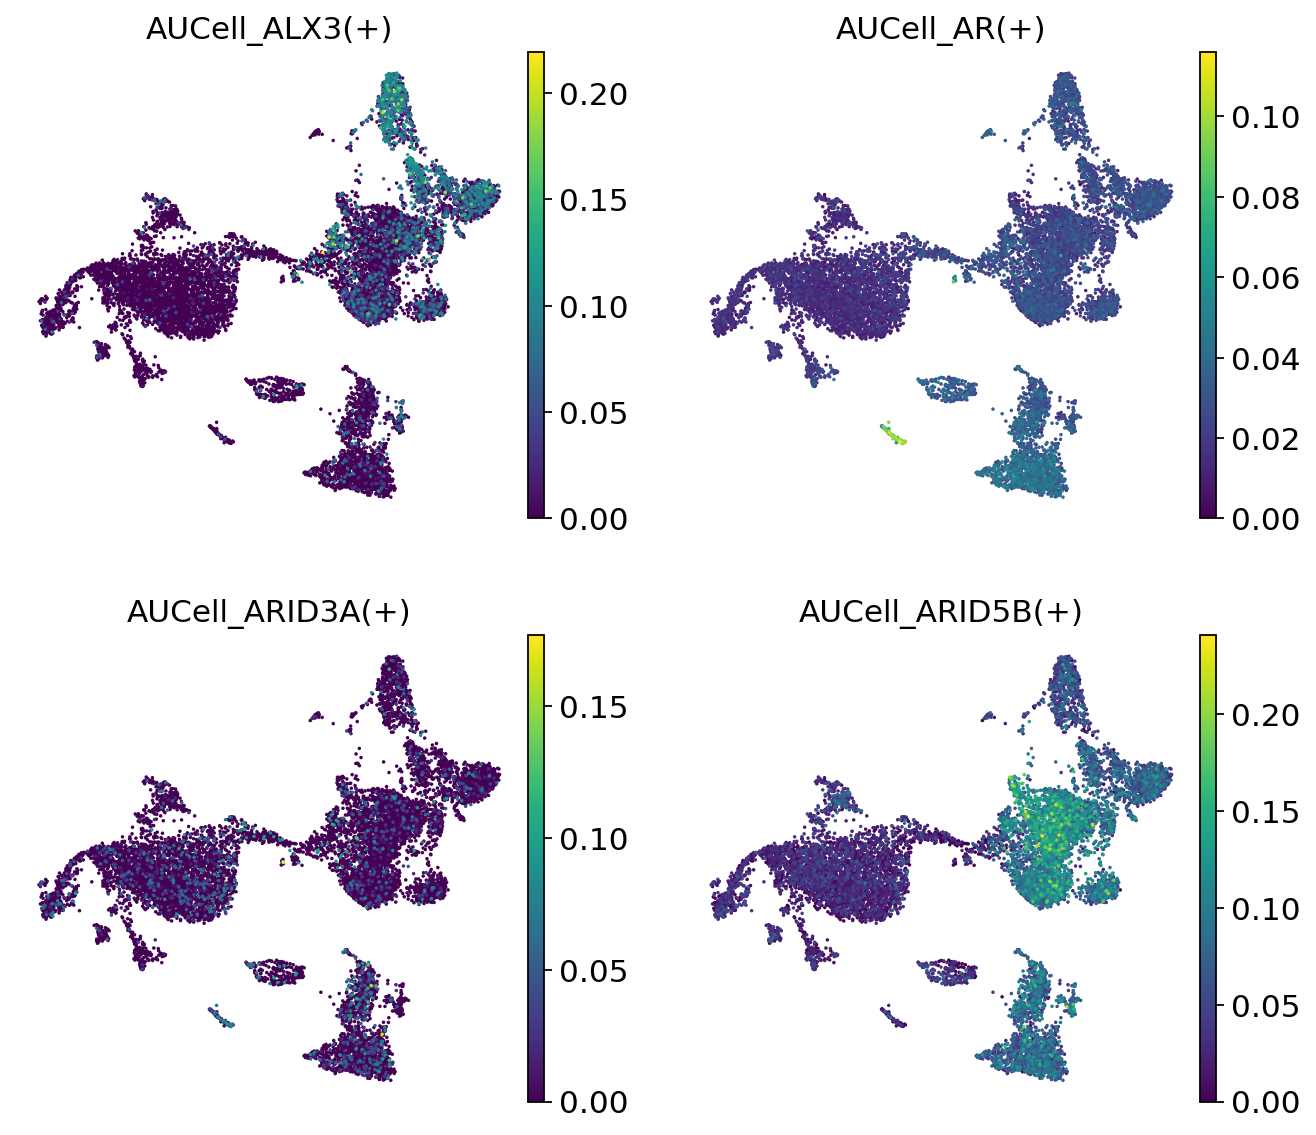

In [ ]:
# ### 4.2 UMAPs Colored by Regulon Activity
if len(auc_mtx_processed.columns) > 0:
    example_regulons_to_plot = list(auc_mtx_processed.columns[:min(4, len(auc_mtx_processed.columns))])
    if 'X_umap' in adata.obsm and example_regulons_to_plot:
        print(f"\nPlotting UMAP for regulons: {example_regulons_to_plot}")
        sc.pl.umap(adata, color=example_regulons_to_plot, ncols=2, cmap='viridis',
                   save="_regulon_activity.png", show=True,
                   legend_loc='on data' if len(adata.obs_names) < 5000 else None)
    else:
        print("Skipping UMAP plots: UMAP coordinates or regulons not available/selected.")
else:
    print("No AUCell regulons found in adata.obs to plot.")


Plotting UMAP for the top 10 regulons with highest mean activity: ['AUCell_JUND(+)', 'AUCell_FOS(+)', 'AUCell_POU2F2(+)', 'AUCell_ZNF467(+)', 'AUCell_FOXP1(+)', 'AUCell_BCL11B(+)', 'AUCell_CEBPA(+)', 'AUCell_IKZF3(+)', 'AUCell_JUNB(+)', 'AUCell_LEF1(+)']


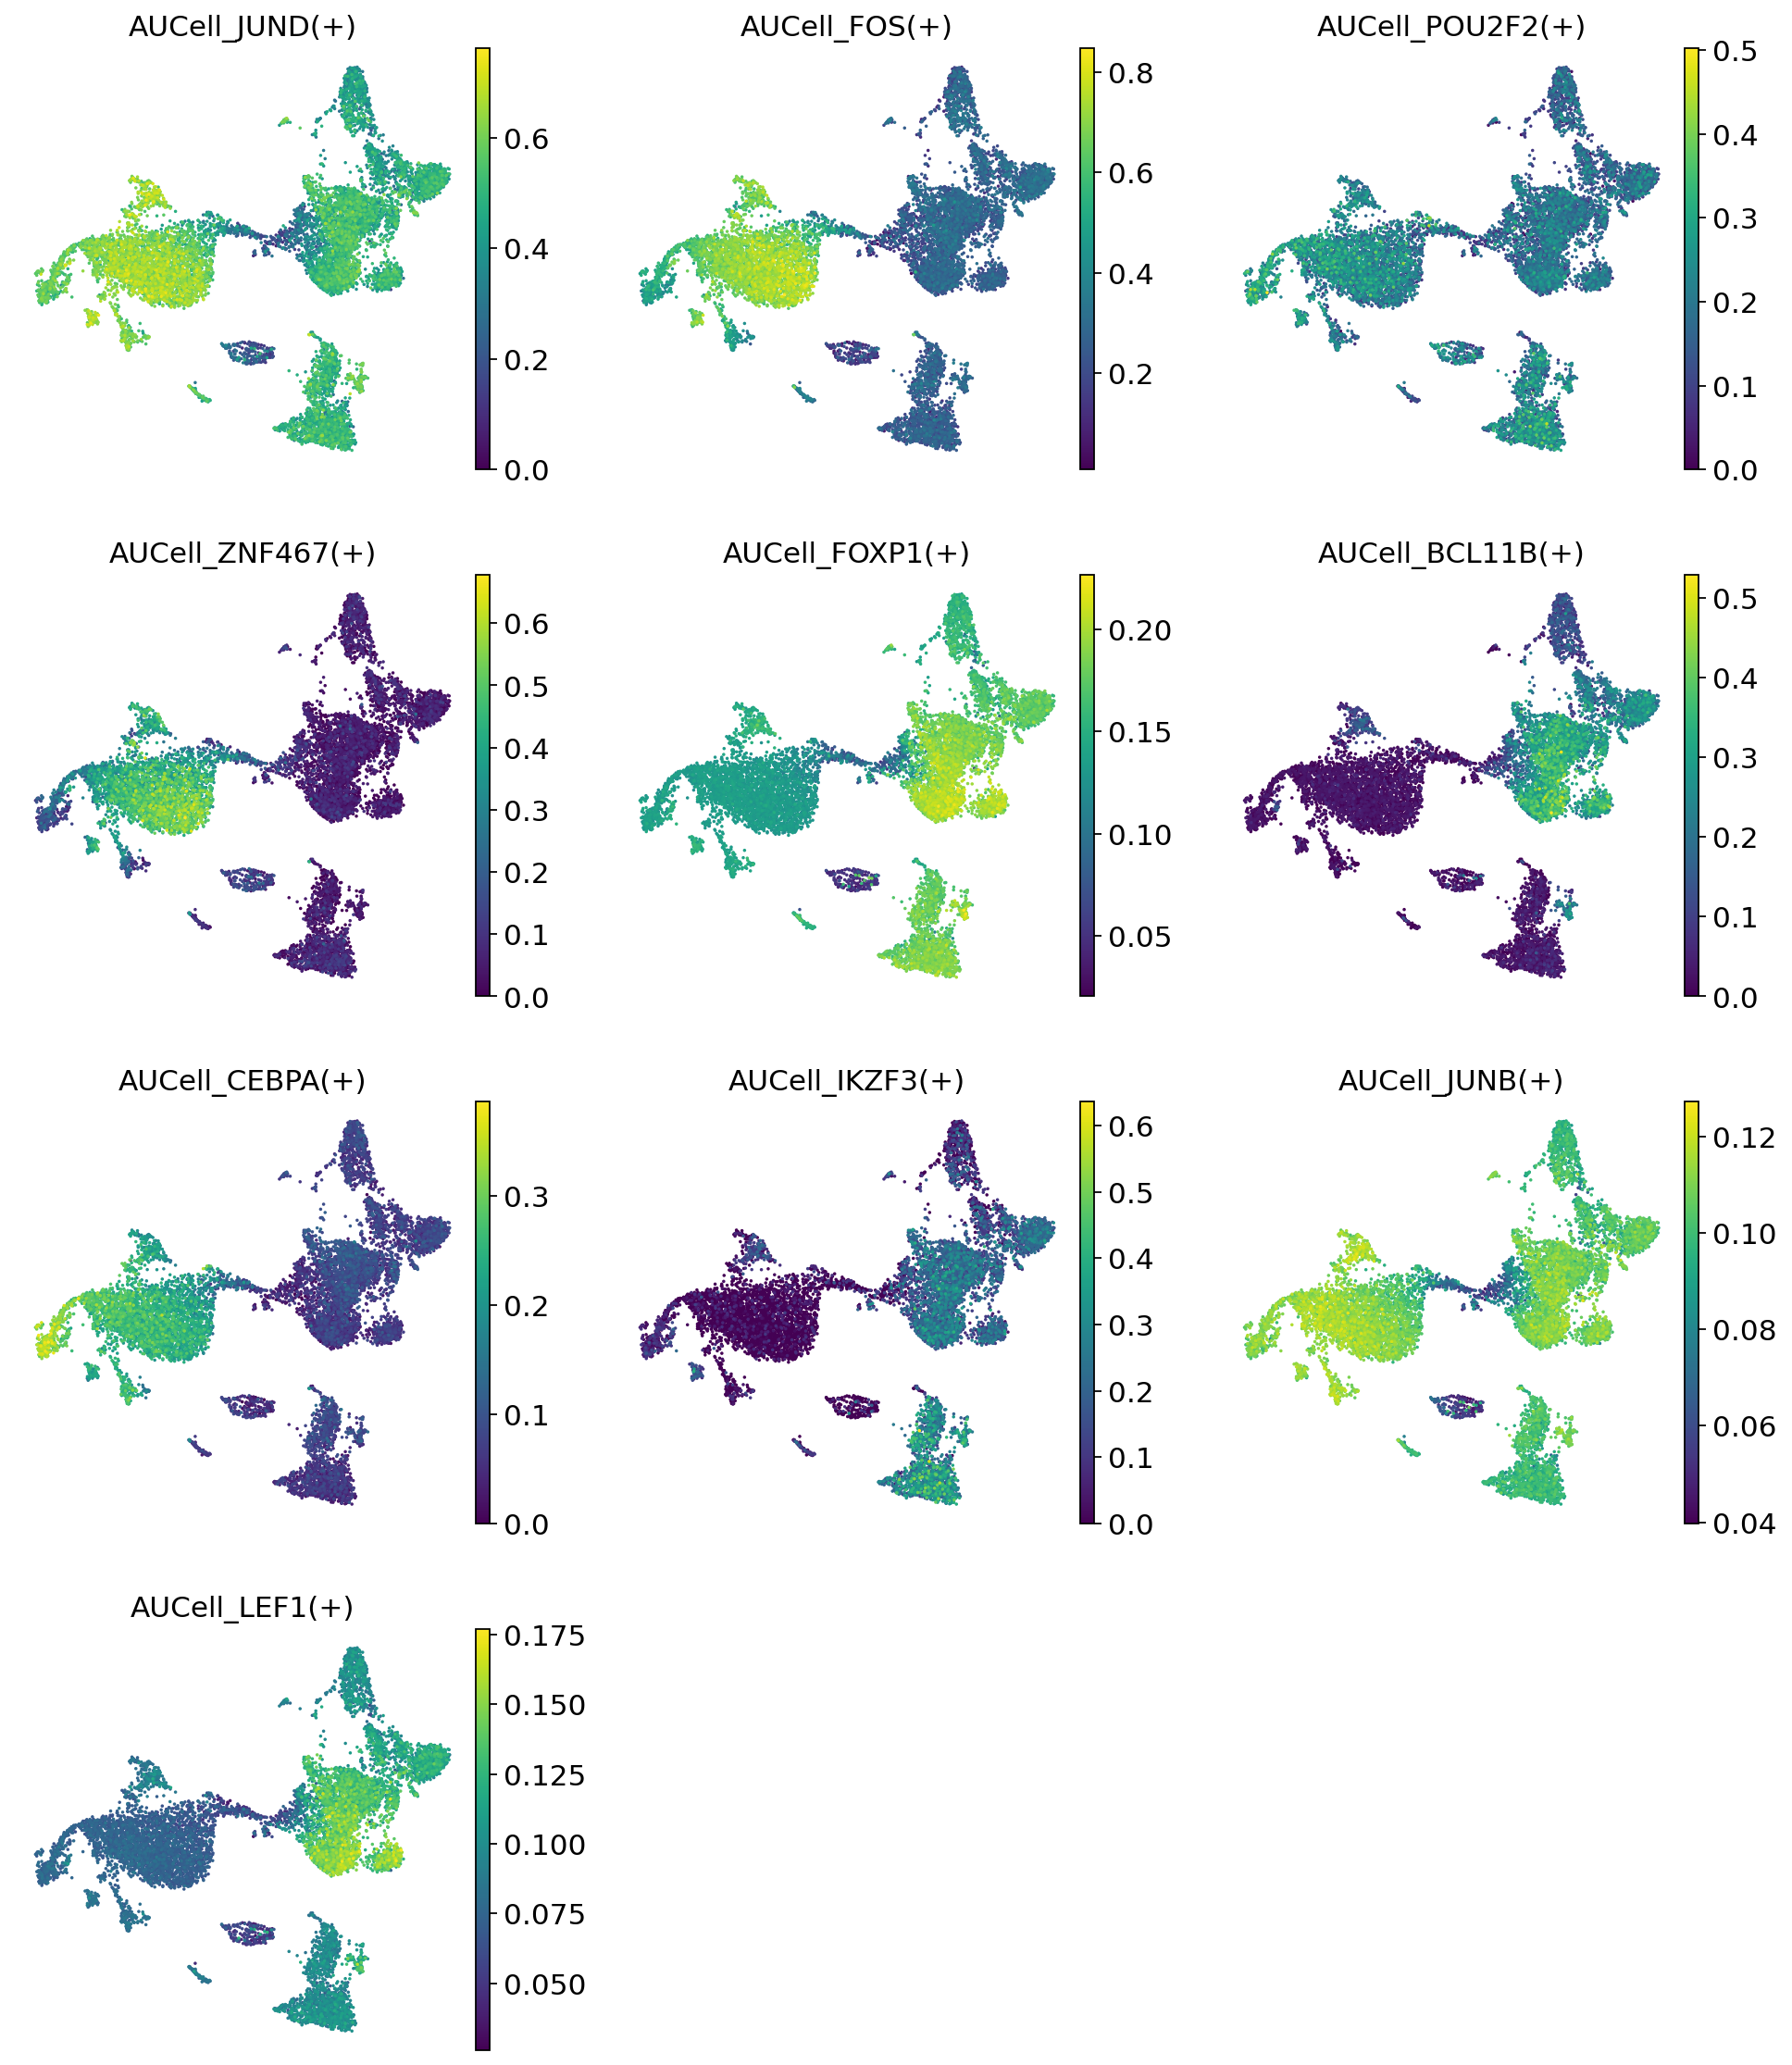

In [35]:
# ### 4.2 UMAPs Colored by Regulon Activity
if len(auc_mtx_processed.columns) > 0:
    # Calculate mean AUCell score for each regulon across all cells
    mean_regulon_activity = auc_mtx_processed.mean(axis=0)
    
    # Get the top 10 regulons with the highest mean activity
    # Ensure we don't try to get more regulons than available
    num_regulons_to_plot = min(10, len(mean_regulon_activity))
    top_10_regulons = mean_regulon_activity.nlargest(num_regulons_to_plot).index.tolist()
    
    if 'X_umap' in adata.obsm and top_10_regulons:
        print(f"\nPlotting UMAP for the top {num_regulons_to_plot} regulons with highest mean activity: {top_10_regulons}")
        # Determine a reasonable number of columns for the plot, e.g., sqrt(num_regulons_to_plot) or fixed like 2 or 3.
        # For up to 10 regulons, 2 or 3 columns is usually fine. Max 5 if using 2 columns.
        ncols_for_plot = 3 if num_regulons_to_plot > 4 else 2
        if num_regulons_to_plot == 1: ncols_for_plot = 1

        sc.pl.umap(adata, color=top_10_regulons, ncols=ncols_for_plot, cmap='viridis',
                   save=f"_top{num_regulons_to_plot}_regulon_activity.png", show=True,
                   legend_loc='on data' if len(adata.obs_names) < 5000 else None)
    else:
        print("Skipping UMAP plots: UMAP coordinates not available or no top regulons identified.")
else:
    print("No AUCell regulons found in adata.obs to plot.")


Plotting heatmap for top 20 variable regulons, grouped by 'leiden_clusters'.


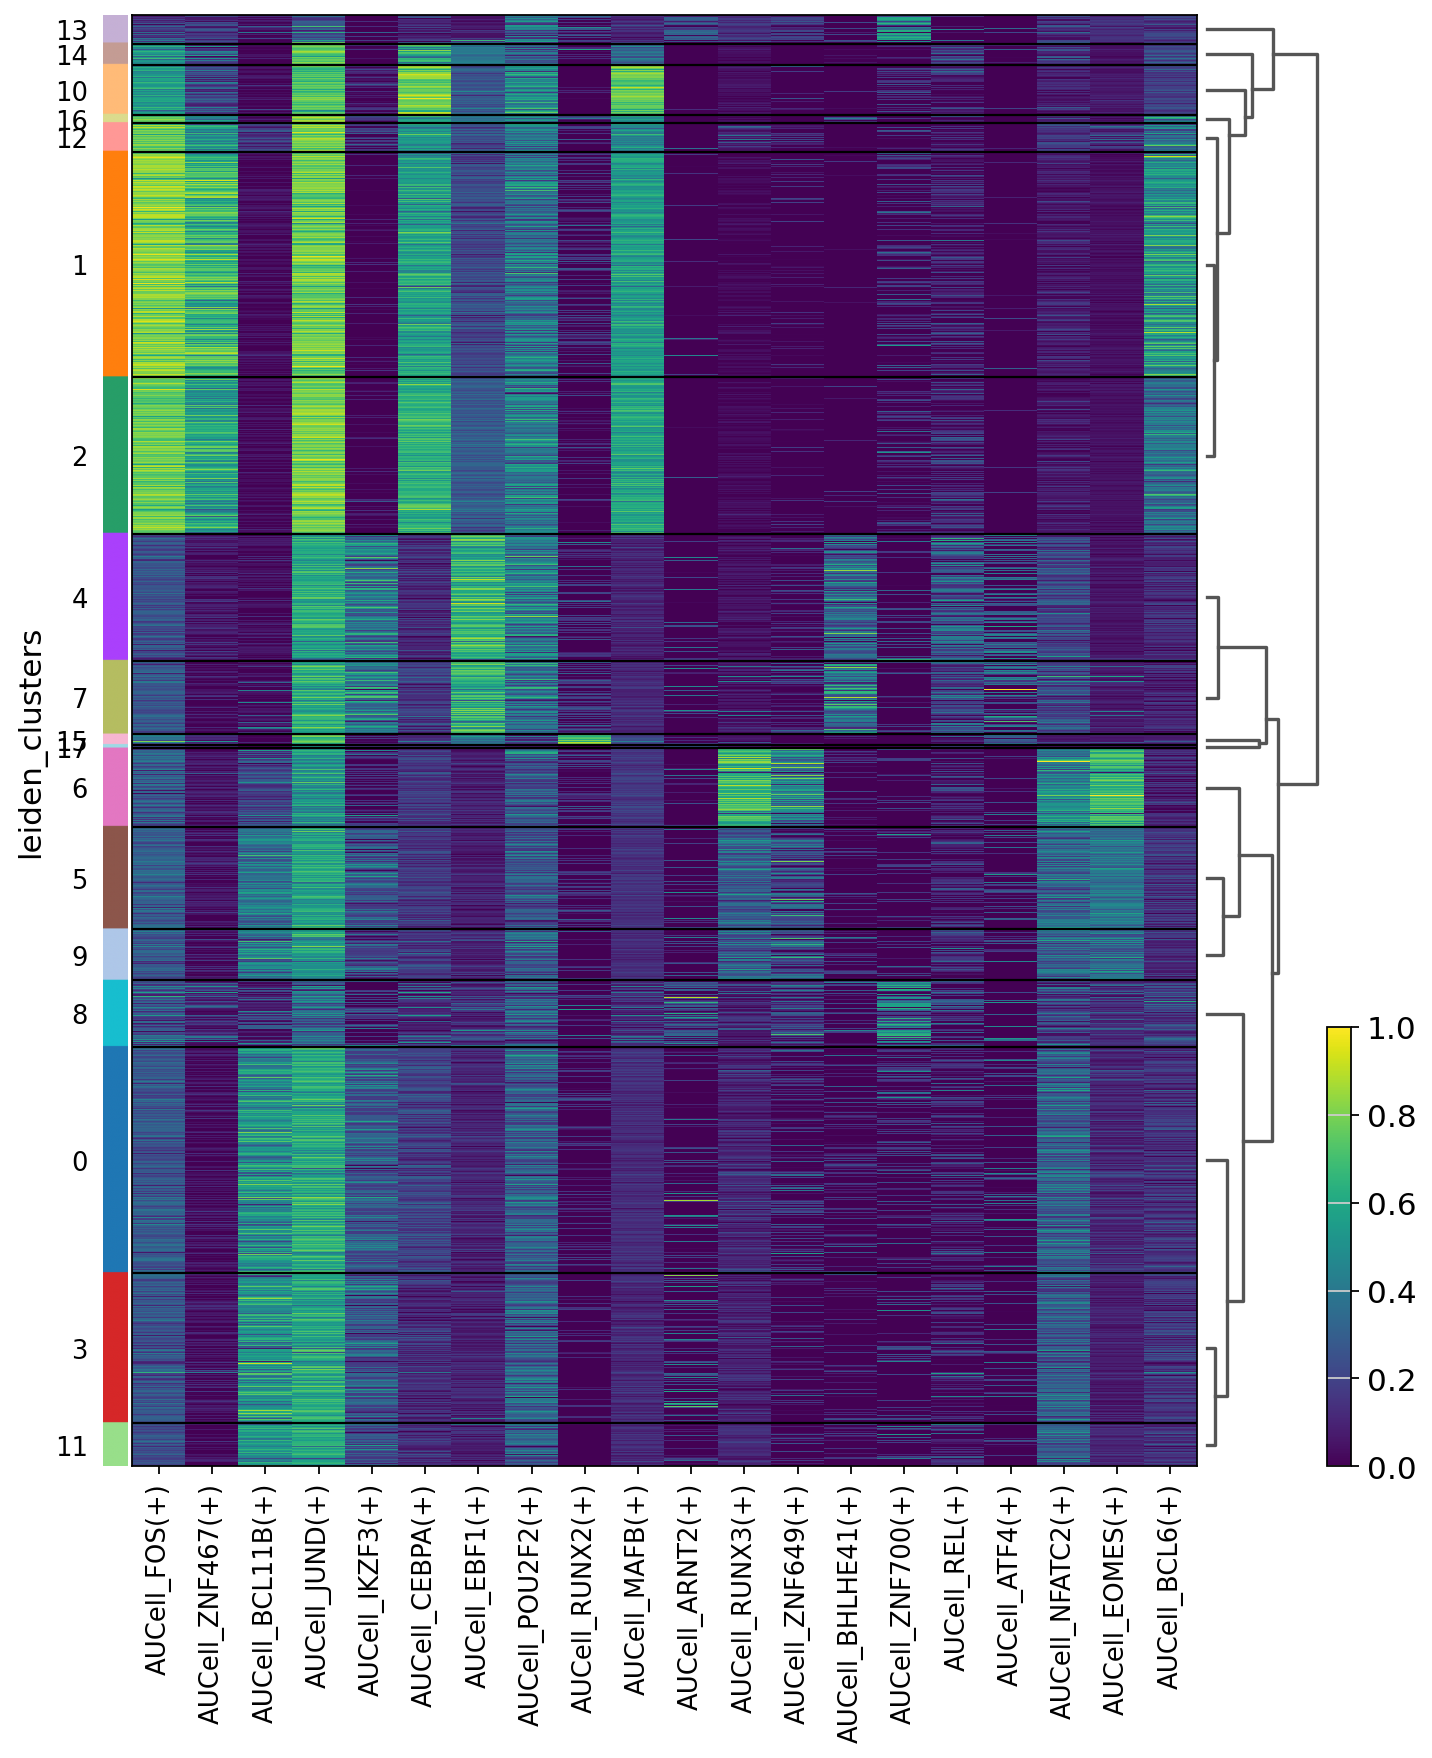

In [37]:

# ### 4.3 Heatmap of Regulon Activity
if CLUSTER_KEY in adata.obs and len(auc_mtx_processed.columns) > 0:
    n_top_variable_regulons = min(20, len(auc_mtx_processed.columns))
    if n_top_variable_regulons > 0:
        regulon_variances = adata.obs[auc_mtx_processed.columns].var()
        top_variable_regulons = regulon_variances.nlargest(n_top_variable_regulons).index.tolist()

        if top_variable_regulons:
            print(f"\nPlotting heatmap for top {len(top_variable_regulons)} variable regulons, grouped by '{CLUSTER_KEY}'.")
            sc.pl.heatmap(
    adata,
    var_names=top_variable_regulons,
    groupby=CLUSTER_KEY,
    cmap='viridis',
    dendrogram=True,
    standard_scale='var',
    figsize=(10, 12),  # Width = 10 inches, Height = 12 inches
    save=f"_heatmap_top_regulons_{CLUSTER_KEY}.png",
    show=True
)

        else:
            print("Could not determine top variable regulons for heatmap.")
    else:
        print("No regulons available for heatmap.")
else:
    print("Skipping heatmap: Clustering key or regulons not available.")


Plotting dotplot for top 20 variable regulons, grouped by 'leiden_clusters'.


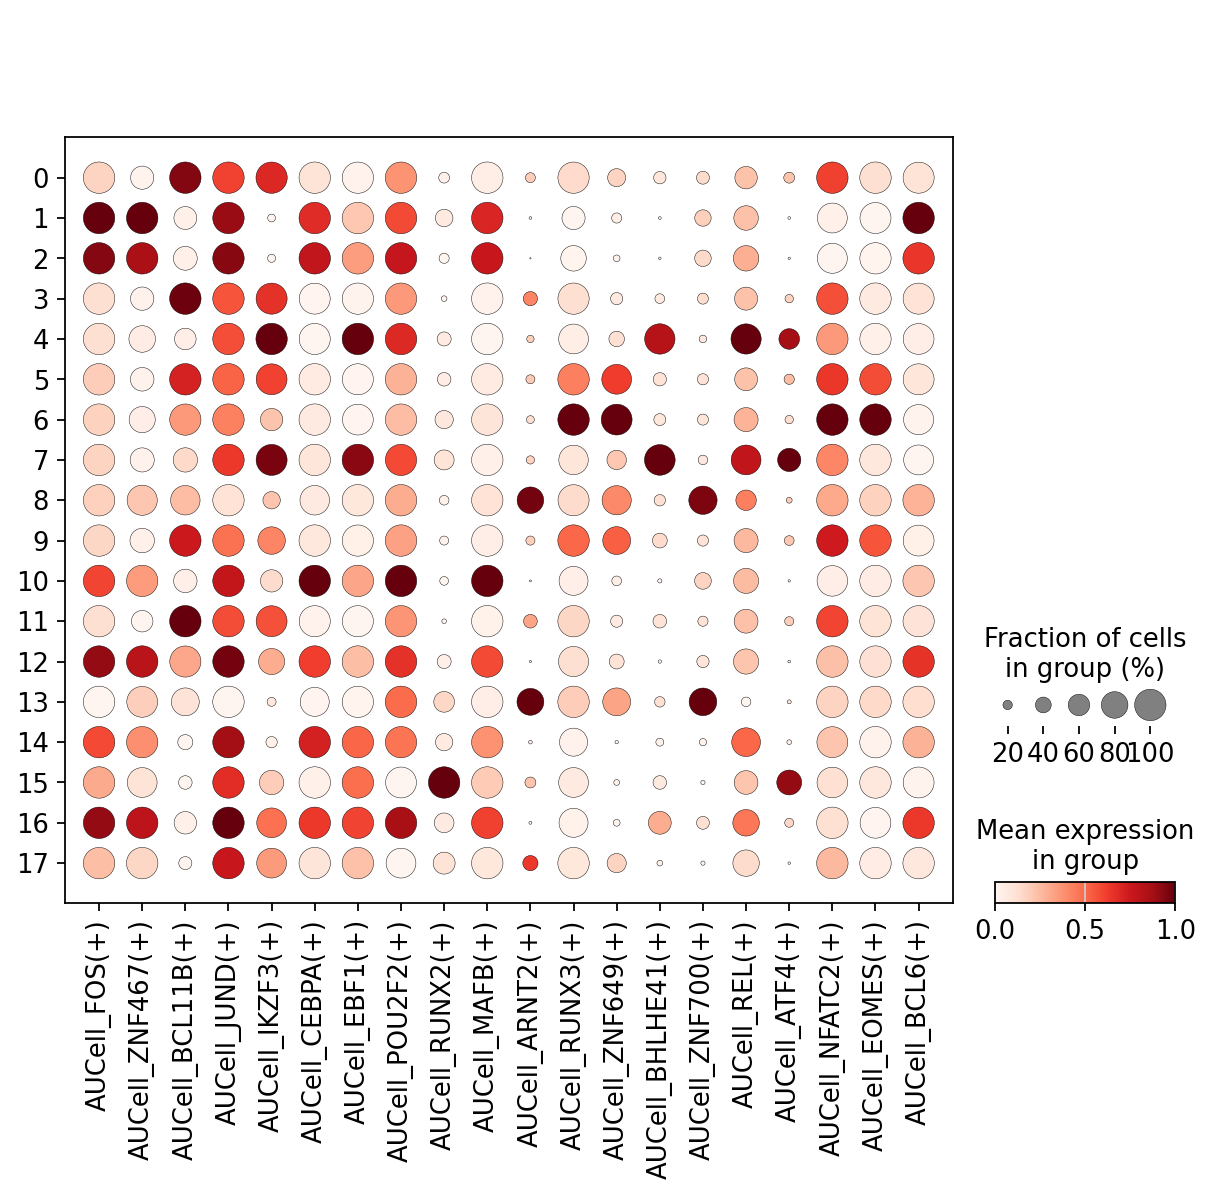

In [38]:
# ### 4.4 Dot Plot of Regulon Activity
if CLUSTER_KEY in adata.obs and len(auc_mtx_processed.columns) > 0:
    if 'top_variable_regulons' in locals() and top_variable_regulons: # Reuse from heatmap section
        print(f"\nPlotting dotplot for top {len(top_variable_regulons)} variable regulons, grouped by '{CLUSTER_KEY}'.")
        sc.pl.dotplot(adata, var_names=top_variable_regulons, groupby=CLUSTER_KEY,
                      standard_scale='var',
                      save=f"_dotplot_top_regulons_{CLUSTER_KEY}.png", show=True)
    elif len(auc_mtx_processed.columns) > 0: # Fallback if top_variable_regulons not defined
        fallback_regulons_dotplot = list(auc_mtx_processed.columns[:min(20, len(auc_mtx_processed.columns))])
        print(f"\nPlotting dotplot for first {len(fallback_regulons_dotplot)} regulons, grouped by '{CLUSTER_KEY}'.")
        sc.pl.dotplot(adata, var_names=fallback_regulons_dotplot, groupby=CLUSTER_KEY,
                      standard_scale='var',
                      save=f"_dotplot_fallback_regulons_{CLUSTER_KEY}.png", show=True)
    else:
        print("No regulons available for dotplot.")
else:
    print("Skipping dotplot: Clustering key or regulons not available.")


Plotting dotplot for top 20 highly active regulons, grouped by 'leiden_clusters'.


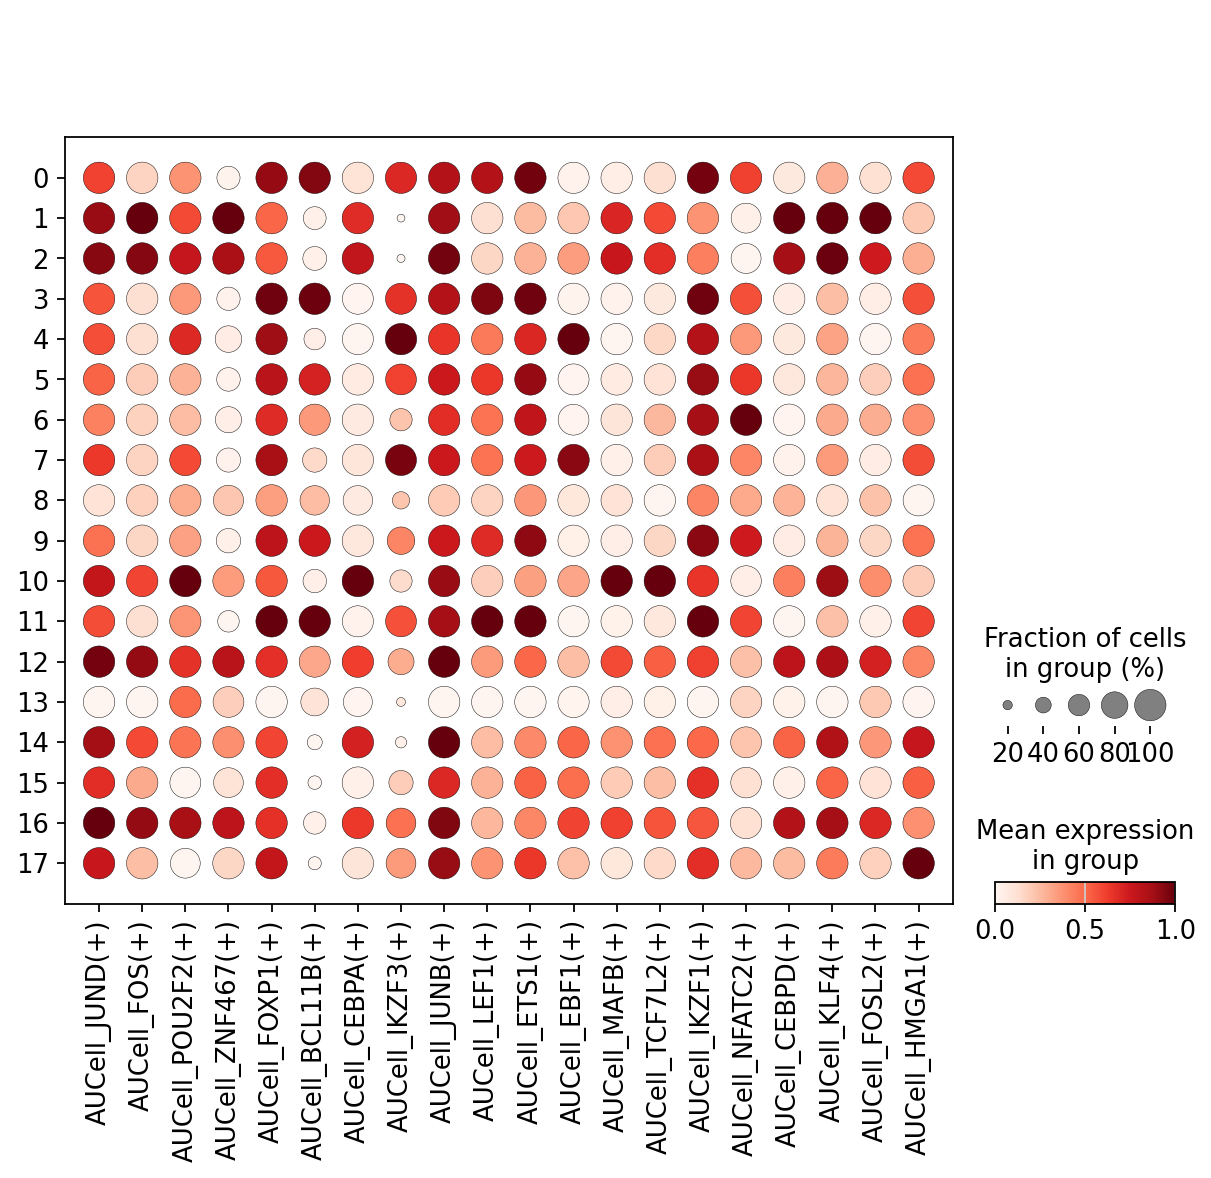

In [39]:
# Step 1: Compute mean activity per regulon (across all cells)
mean_auc_per_regulon = auc_mtx_processed.mean(axis=0)

# Step 2: Select top 20 highly active regulons
top_active_regulons = mean_auc_per_regulon.sort_values(ascending=False).head(20).index.tolist()

# Step 3: Plot
if CLUSTER_KEY in adata.obs and len(top_active_regulons) > 0:
    print(f"\nPlotting dotplot for top {len(top_active_regulons)} highly active regulons, grouped by '{CLUSTER_KEY}'.")
    sc.pl.dotplot(
        adata,
        var_names=top_active_regulons,
        groupby=CLUSTER_KEY,
        standard_scale='var',
        save=f"_dotplot_top_active_regulons_{CLUSTER_KEY}.png",
        show=True
    )
else:
    print("Skipping dotplot: Clustering key or top active regulons not available.")

In [41]:
# ## 5. Basic Downstream Analysis

# ### 5.1 Identify Top Regulons per Cluster (Example)
if CLUSTER_KEY in adata.obs and len(auc_mtx_processed.columns) > 0:
    print(f"\nIdentifying top regulons per '{CLUSTER_KEY}' cluster (based on mean AUCell score):")
    mean_auc_per_cluster = adata.obs.groupby(CLUSTER_KEY)[auc_mtx_processed.columns].mean()
    top_n_regulons = 3
    for cluster_id in mean_auc_per_cluster.index:
        top_regulons_for_cluster = mean_auc_per_cluster.loc[cluster_id].nlargest(top_n_regulons)
        print(f"  Cluster {cluster_id}:")
        for regulon, score in top_regulons_for_cluster.items():
            print(f"    - {regulon}: {score:.4f}")
else:
    print("Skipping identification of top regulons per cluster: Clustering key or regulons not available.")


Identifying top regulons per 'leiden_clusters' cluster (based on mean AUCell score):
  Cluster 0:
    - AUCell_JUND(+): 0.4694
    - AUCell_BCL11B(+): 0.2672
    - AUCell_FOS(+): 0.2431
  Cluster 1:
    - AUCell_FOS(+): 0.6816
    - AUCell_JUND(+): 0.5875
    - AUCell_ZNF467(+): 0.4455
  Cluster 2:
    - AUCell_FOS(+): 0.6498
    - AUCell_JUND(+): 0.6026
    - AUCell_ZNF467(+): 0.3858
  Cluster 3:
    - AUCell_JUND(+): 0.4482
    - AUCell_BCL11B(+): 0.2800
    - AUCell_FOS(+): 0.2222
  Cluster 4:
    - AUCell_JUND(+): 0.4562
    - AUCell_IKZF3(+): 0.2577
    - AUCell_EBF1(+): 0.2380
  Cluster 5:
    - AUCell_JUND(+): 0.4317
    - AUCell_FOS(+): 0.2551
    - AUCell_BCL11B(+): 0.2060
  Cluster 6:
    - AUCell_JUND(+): 0.3943
    - AUCell_FOS(+): 0.2463
    - AUCell_RUNX3(+): 0.2010
  Cluster 7:
    - AUCell_JUND(+): 0.4809
    - AUCell_IKZF3(+): 0.2485
    - AUCell_FOS(+): 0.2410
  Cluster 8:
    - AUCell_JUND(+): 0.2645
    - AUCell_FOS(+): 0.2481
    - AUCell_POU2F2(+): 0.1402
  Clust

/tmp/ipykernel_1731136/3001765313.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_auc_per_cluster = adata.obs.groupby(CLUSTER_KEY)[auc_mtx_processed.columns].mean()
